## sklearn

In [13]:
from sklearn.datasets import fetch_openml
import numpy as np
mnist = fetch_openml('mnist_784',version=1,data_home=r'./')  # 14M.

print(mnist.keys())

print(mnist['data'].shape, mnist['target'].shape)   # 'data', 'target'모두 정수 numpy array(dtype없음)
print(mnist['data'].dtype, mnist['target'].dtype)

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])
(70000, 784) (70000,)
float64 object


In [11]:
mnist['data'].dtype, mnist['target'].dtype

(dtype('float64'), dtype('O'))

In [14]:
X = (mnist['data']/255).astype(np.float32)
Y = mnist['target'].astype(np.uint8)

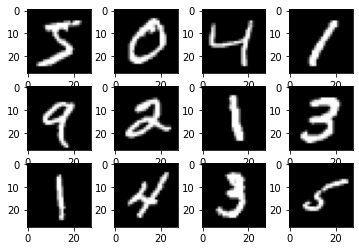

In [18]:
import matplotlib.pyplot as plt

for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(X[i].reshape(28,28),cmap='gray')

## Tensorflow

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()  # numpy array 
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)  # (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)

dataset = tf.data.Dataset.from_tensor_slices((tf.cast(x_train[...,tf.newaxis]/255, tf.float32), tf.cast(y_train,tf.int32)))
dataset = dataset.shuffle(1000).batch(12)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


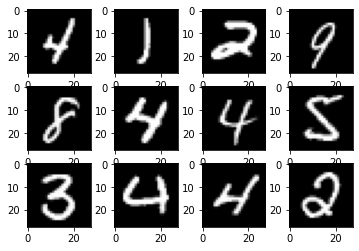

In [30]:
it = iter(dataset)
x,y = it.next()
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(x[i].numpy()[:,:,0],cmap='gray')

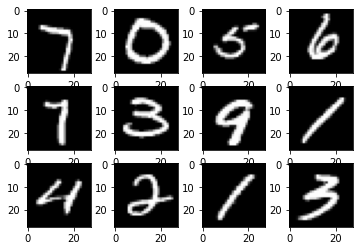

In [33]:
for x,y in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(x[i].numpy()[:,:,0],cmap='gray')

## pytorch

In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
from torch import nn
import numpy as np

In [2]:
# 다운 받은 data는 PIL.Image.Image(np.array로 변환해 보면 shape(28,28) uint8)이다. transform을 통해 tensor로 변환해야 하다.
# (28,28)이기 때문에, reshape이 필요없다.

download_root = r'D:\hccho\CommonDataset\mnist'  #---> 아래에 MNIST- raw, processed 2개의 subdirectory가 생성된다. 

transform = transforms.Compose([transforms.ToTensor()]) # channel dim이 생성(1,28,28)

train_dataset = datasets.MNIST(download_root, transform=transform, train=True, download=True)   # transform을 넣어야 한다.
test_dataset = datasets.MNIST(download_root, transform=transform, train=False, download=True)

#train_dataset[0][0].show()  # PIL.Image.Image

print(len(train_dataset),len(test_dataset))   # 60000(1,28,28), 10000

train_loader = DataLoader(train_dataset,batch_size=12,shuffle=True)

Extracting D:\hccho\CommonDataset\mnist\MNIST\raw\train-images-idx3-ubyte.gz to D:\hccho\CommonDataset\mnist\MNIST\raw


Extracting D:\hccho\CommonDataset\mnist\MNIST\raw\train-labels-idx1-ubyte.gz to D:\hccho\CommonDataset\mnist\MNIST\raw


Extracting D:\hccho\CommonDataset\mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to D:\hccho\CommonDataset\mnist\MNIST\raw


Extracting D:\hccho\CommonDataset\mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to D:\hccho\CommonDataset\mnist\MNIST\raw
Processing...


C:\Anaconda3\envs\tf2\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!
60000 10000


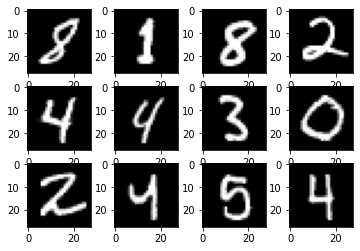

In [3]:
it = iter(train_loader)
x,y = it.next()
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(x[i,0].numpy(),cmap='gray')

In [4]:
x.shape

torch.Size([12, 1, 28, 28])

## Classification

- 결론을 말하면, FC layer만으로는 그림판으로 일력한 숫자를 판별하지 못하다.
- CNN으로 모델을 구성하면 잘 판별한다
- image를 만들때, (28,28)로 만들지 말고, (100,100)정도로 만들면 resize과정에서 mnist dataset과 유사해 진다.


In [197]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 784 # 28x28
hidden_size = 500 
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root=download_root, 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)   # ---> Dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)


test_dataset = torchvision.datasets.MNIST(root=download_root, 
                                          train=False, 
                                          transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [198]:
print(type(train_dataset))
len(train_dataset), len(train_loader), len(test_dataset), len(test_loader)

torchvision.datasets.mnist.MNIST


(60000, 600, 10000, 100)

In [168]:
# https://www.youtube.com/playlist?list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4
# https://github.com/python-engineer/pytorch-examples
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.dropout = nn.Dropout(0.3)
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.dropout(x)
        out = self.l1(out)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

# http://www.ccom.ucsd.edu/~cdeotte/programs/MNIST.html
class NeuralNet2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet2, self).__init__()
        self.pooling = nn.AvgPool1d(4)
        self.l1 = nn.Linear(196,100)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(100, num_classes)  
    
    def forward(self, x):
        out = torch.unsqueeze(x,1)
        out = self.pooling(out)
        out = torch.squeeze(out,1)
        out = self.l1(out)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L3 ImgIn shape=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer4(out)
        out = self.fc2(out)
        return out


In [169]:
#model = NeuralNet(input_size, hidden_size, num_classes).to(device)
#model = NeuralNet2(input_size, hidden_size, num_classes).to(device)   # ===> 별 효과 없음.
model = CNN().to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [170]:
# Train the model
model.train()
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        
        #images = images.reshape(-1, 28*28).to(device)
        images = images.to(device)
        
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/5], Step [100/600], Loss: 0.3064
Epoch [1/5], Step [200/600], Loss: 0.1167
Epoch [1/5], Step [300/600], Loss: 0.0879
Epoch [1/5], Step [400/600], Loss: 0.0886
Epoch [1/5], Step [500/600], Loss: 0.0328
Epoch [1/5], Step [600/600], Loss: 0.1346
Epoch [2/5], Step [100/600], Loss: 0.0756
Epoch [2/5], Step [200/600], Loss: 0.0086
Epoch [2/5], Step [300/600], Loss: 0.0121
Epoch [2/5], Step [400/600], Loss: 0.0905
Epoch [2/5], Step [500/600], Loss: 0.0275
Epoch [2/5], Step [600/600], Loss: 0.0478
Epoch [3/5], Step [100/600], Loss: 0.0045
Epoch [3/5], Step [200/600], Loss: 0.0888
Epoch [3/5], Step [300/600], Loss: 0.0224
Epoch [3/5], Step [400/600], Loss: 0.0243
Epoch [3/5], Step [500/600], Loss: 0.0156
Epoch [3/5], Step [600/600], Loss: 0.0371
Epoch [4/5], Step [100/600], Loss: 0.0043
Epoch [4/5], Step [200/600], Loss: 0.0874
Epoch [4/5], Step [300/600], Loss: 0.0829
Epoch [4/5], Step [400/600], Loss: 0.0232
Epoch [4/5], Step [500/600], Loss: 0.0071
Epoch [4/5], Step [600/600], Loss:

In [172]:
model.eval()
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        
        #images = images.reshape(-1, 28*28).to(device)
        images = images.to(device)
        
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 99.07 %


## 그림판으로 그린 숫자 판별

In [218]:
import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
digit_files = glob.glob('*.png')
print(digit_files)


transform_test = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.Resize((28,28),interpolation=2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))
                                    ])

class MyDataset(Dataset): 
    """ Diabetes dataset.""" 
    # Initialize your data, download, etc. 
    def __init__(self,digit_files,transform=None): 
        self.digit_files = digit_files
        self.images = [Image.open(f) for f in digit_files]
        self.nSamples = len(digit_files)
        
        if transform:
            self.transform = transform
        else:
            self.transform = transforms.ToTensor()
        
    
    def __len__(self):
        return self.nSamples
    def __getitem__(self, index): 
        return self.transform(self.images[index]), self.digit_files[index]


my_test_dataset = MyDataset(digit_files,transform_test)
my_test_dataloader = DataLoader(my_test_dataset, batch_size=1,shuffle=False)


it = iter(my_test_dataloader)
a,b = it.next()
a.shape, b


['eight.png', 'mnist_digit.png', 'my_digit2.png', 'my_digit4.png', 'my_digit5.png', 'my_digit9.png', 'resized_fig.png', 'resized_mnist_fig.png', 'resized_mydigit_fig.png', 'seven.png', 'three.png']


(torch.Size([1, 1, 28, 28]), ('eight.png',))

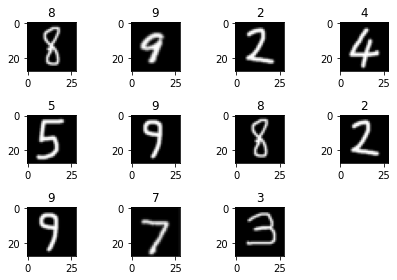

In [219]:
model.eval()
n_image = len(digit_files)
ncols = 4
nrows = np.int(np.ceil(n_image/ncols))

for i, (x,f) in enumerate(my_test_dataloader):
    _,pred = model(x).max(-1)
    plt.subplot(nrows,ncols,i+1)
    plt.imshow(x[0,0].numpy(),cmap='gray')
    plt.title(pred[0].item())

plt.tight_layout()

## predict 1 image

In [179]:
def predict(model,img):
    model.eval()
    #img_tensor = transform_test(img).reshape(-1, 28*28).to(device) # (1,28,28)
    img_tensor = transform_test(img).unsqueeze(0).to(device) # (1,28,28)

    _,pred = model(img_tensor).max(-1)
    return pred[0]

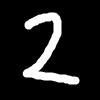

In [191]:
#path = 'seven2.png'
#path = 'eight.png'
#path = 'seven.png'
#path = 'three.png'
#path = 'five.png'
#path = 'my_digit4.png'
path = 'my_digit2.png'
#path = 'mnist_digit.png'
# img = Image.open(path).convert('L').resize((28, 28))
# img_tensor = transform(img).reshape(-1,28*28)


img = Image.open(path)
#img = Image.fromarray(drawing_image)
img

In [192]:
tr = transforms.Grayscale(num_output_channels=1)(img)
tr = transforms.Resize((28,28))(tr)
temp = np.array(tr).astype(np.uint8)  #, img_tensor.shape
print(temp.dtype)
np.savetxt('mnist_digit.txt',temp,fmt='%i')
im = Image.fromarray(temp)
im.save("resized_mnist_fig.png")
im

uint8


In [194]:
predict(model,img)

tensor(2)

In [193]:
#a = transform_test(img).reshape(-1,28*28).to(device)
a = transform_test(img).unsqueeze(0).to(device) # (1,28,28)
model(a)

tensor([[-17.1221,  -0.3230,  53.6416,  -0.4363, -28.2892, -45.1257, -29.2069,
         -14.9273,   1.1702, -17.5207]], grad_fn=<AddmmBackward>)

## Drawing

In [13]:
import cv2
import numpy as np

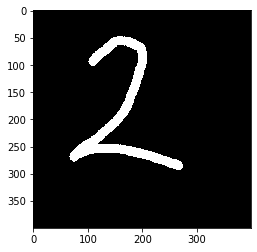

In [35]:
# creating a 600 x 600 pixels canvas for mouse drawing
canvas = np.ones((600,600), dtype="uint8") * 255
# designating a 400 x 400 pixels point of interest on which digits will be drawn
canvas[100:500,100:500] = 0

start_point = None
end_point = None
is_drawing = False

def draw_line(img,start_at,end_at):
    cv2.line(img,start_at,end_at,255,15)

def on_mouse_events(event,x,y,flags,params):
    global start_point
    global end_point
    global canvas
    global is_drawing
    if event == cv2.EVENT_LBUTTONDOWN:
        if is_drawing:
            start_point = (x,y)
    elif event == cv2.EVENT_MOUSEMOVE:
        if is_drawing:
            end_point = (x,y)
            draw_line(canvas,start_point,end_point)
            start_point = end_point
    elif event == cv2.EVENT_LBUTTONUP:
        is_drawing = False


cv2.namedWindow("Test Canvas")
cv2.setMouseCallback("Test Canvas", on_mouse_events)


while(True):
    cv2.imshow("Test Canvas", canvas)
    key = cv2.waitKey(1) & 0xFF 
    if key == ord('s'):
        is_drawing = True
    elif key == ord('p'):
        is_drawing = False
    elif key == ord('c'):
        canvas[100:500,100:500] = 0
    elif key == ord('d'):
        drawing_image = canvas[100:500,100:500]
        break
        #result = net.predict(image)
        #print("PREDICTION : ",result)

cv2.destroyAllWindows()
plt.imshow(drawing_image,cmap='gray')

In [9]:
drawing_image.shape

(400, 400)

In [12]:
img = Image.fromarray(drawing_image)

In [ ]:
img

## Drawing2

In [41]:
from PIL import ImageTk, Image, ImageDraw
import PIL
from tkinter import *

width = 200
height = 200
center = height//2
white = (255, 255, 255)
green = (0,128,0)

def save():
    filename = "image.png"
    image1.save(filename)

def paint(event):
    # python_green = "#476042"
    x1, y1 = (event.x - 1), (event.y - 1)
    x2, y2 = (event.x + 1), (event.y + 1)
    cv.create_oval(x1, y1, x2, y2, fill="black",width=5)
    draw.line([x1, y1, x2, y2],fill="black",width=5)

root = Tk()

# Tkinter create a canvas to draw on
cv = Canvas(root, width=width, height=height, bg='white')
cv.pack()

# PIL create an empty image and draw object to draw on
# memory only, not visible
image1 = PIL.Image.new("RGB", (width, height), white)
draw = ImageDraw.Draw(image1)

# do the Tkinter canvas drawings (visible)
# cv.create_line([0, center, width, center], fill='green')

cv.pack(expand=YES, fill=BOTH)
cv.bind("<B1-Motion>", paint)

# do the PIL image/draw (in memory) drawings
# draw.line([0, center, width, center], green)

# PIL image can be saved as .png .jpg .gif or .bmp file (among others)
# filename = "my_drawing.png"
# image1.save(filename)
button=Button(text="save",command=save)
button.pack()
root.mainloop()

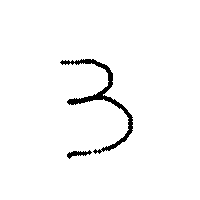

In [42]:
image1